_Lambda School Data Science, Unit 2_
 
# Regression 2 Sprint Challenge: Predict drugstore sales 🏥

For your Sprint Challenge, you'll use real-world sales data from a German drugstore chain, from Jan 2, 2013 — July 31, 2015.

You are given three dataframes:

- `train`: historical sales data for 100 stores
- `test`: historical sales data for 100 different stores
- `store`: supplemental information about the stores


The train and test set do _not_ have different date ranges. But they _do_ have different store ids. Your task is _not_ to forecast future sales from past sales. **Your task is to predict sales at unknown stores, from sales at known stores.**

In [1]:
import pandas as pd
train = pd.read_csv('https://drive.google.com/uc?export=download&id=1E9rgiGf1f_WL2S4-V6gD7ZhB8r8Yb_lE')
test = pd.read_csv('https://drive.google.com/uc?export=download&id=1vkaVptn4TTYC9-YPZvbvmfDNHVR8aUml')
store = pd.read_csv('https://drive.google.com/uc?export=download&id=1rZD-V1mWydeytptQfr-NL7dBqre6lZMo')
assert train.shape == (78400, 7)
assert test.shape == (78400, 7)
assert store.shape == (200, 10)

The dataframes have a variety of columns:

- **Store** - a unique Id for each store
- **DayOfWeek** - integer, 1-6
- **Date** - the date, from Jan 2, 2013 — July 31, 2015.
- **Sales** - the units of inventory sold on a given date (this is the target you are predicting)
- **Customers** - the number of customers on a given date
- **Promo** - indicates whether a store is running a promo on that day
- **SchoolHoliday** - indicates the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

This Sprint Challenge has three parts. To demonstrate mastery on each part, do all the required instructions. To earn a score of "3" for the part, also do the stretch goals.

## 1. Wrangle relational data, Log-transform the target
- Merge the `store` dataframe with the `train` and `test` dataframes. 
- Arrange the X matrix and y vector for the train and test sets.
- Log-transform the target for the train and test set.
- Plot the target's distribution for the train set, before and after the transformation.

#### Stretch goals
- Engineer 3+ more features.

In [2]:
# Let's do our imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import os
import warnings
import urllib.request
from scipy.stats import randint, uniform
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from xgboost import XGBRegressor
from glob import glob
%matplotlib inline

In [3]:
train.columns.to_list()

['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Promo', 'SchoolHoliday']

In [4]:
test.columns.to_list()

['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Promo', 'SchoolHoliday']

In [5]:
store.columns.to_list()

['Store',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval']

In [6]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday
count,78400.000000,78400.000000,78400.000000,78400.000000,78400.000000,78400.000000
mean,544.690000,3.506378,6988.430778,826.109847,0.450255,0.195268
std,325.893217,1.710560,2824.069622,316.205067,0.497522,0.396409
min,4.000000,1.000000,1712.000000,206.000000,0.000000,0.000000
25%,259.250000,2.000000,5005.000000,599.000000,0.000000,0.000000
50%,550.000000,3.000000,6370.000000,757.000000,0.000000,0.000000
75%,826.500000,5.000000,8303.000000,993.000000,1.000000,0.000000
max,1113.000000,6.000000,27265.000000,3360.000000,1.000000,1.000000


In [7]:
train['Store'].value_counts()

511     784
340     784
268     784
333     784
270     784
398     784
912     784
593     784
914     784
1106    784
211     784
531     784
725     784
447     784
278     784
599     784
344     784
472     784
217     784
1113    784
923     784
987     784
988     784
221     784
12      784
843     784
459     784
11      784
768     784
896     784
       ... 
379     784
763     784
957     784
958     784
1010    784
304     784
801     784
48      784
1057    784
34      784
802     784
163     784
101     784
549     784
487     784
551     784
679     784
680     784
938     784
1002    784
683     784
44      784
236     784
109     784
237     784
301     784
110     784
1007    784
1071    784
576     784
Name: Store, Length: 100, dtype: int64

In [8]:
train.head(10)

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday
0,4,5,2015-07-31,13995,1498,1,1
1,8,5,2015-07-31,8492,833,1,1
2,11,5,2015-07-31,10457,1236,1,1
3,12,5,2015-07-31,8959,962,1,1
4,34,5,2015-07-31,11144,1162,1,1
5,44,5,2015-07-31,6670,665,1,1
6,48,5,2015-07-31,3874,390,1,1
7,68,5,2015-07-31,11187,1341,1,1
8,73,5,2015-07-31,6026,537,1,1
9,101,5,2015-07-31,11075,915,1,1


In [9]:
# We can add a feature to train and test, Weekend

train['Weekend'] = train[['DayOfWeek']] == 6
train.sample(10)

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday,Weekend
37316,197,5,2014-05-09,4230,518,1,0,False
28727,270,3,2014-08-20,9030,1157,1,1,False
58639,439,1,2013-08-26,9891,1151,1,0,False
20077,840,1,2014-12-01,11828,1389,1,0,False
18477,840,5,2014-12-19,9162,1285,1,0,False
16594,1057,3,2015-01-14,5824,571,1,0,False
51911,110,3,2013-11-13,3825,542,0,0,False
15915,185,3,2015-01-21,5001,430,0,0,False
6193,1033,3,2015-05-20,15145,1375,1,0,False
2451,566,5,2015-07-03,6007,646,1,0,False


In [10]:
test['Store'].value_counts()

1087    784
856     784
595     784
148     784
212     784
468     784
596     784
469     784
150     784
662     784
87      784
600     784
281     784
959     784
282     784
538     784
730     784
668     784
1053    784
222     784
606     784
1054    784
31      784
352     784
722     784
594     784
849     784
721     784
643     784
452     784
       ... 
1085    784
63      784
319     784
767     784
240     784
367     784
546     784
175     784
355     784
419     784
1059    784
484     784
421     784
741     784
230     784
422     784
935     784
1063    784
104     784
360     784
554     784
874     784
107     784
363     784
811     784
173     784
622     784
1070    784
47      784
320     784
Name: Store, Length: 100, dtype: int64

In [11]:
test['Weekend'] = test[['DayOfWeek']] == 6
test.sample(10)

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday,Weekend
44663,643,1,2014-02-10,7259,990,0,0,False
12940,432,3,2015-02-25,9708,1542,0,0,False
34766,662,3,2014-06-11,7009,648,0,0,False
24987,944,6,2014-10-04,11037,1622,0,0,True
72480,856,2,2013-03-12,5150,828,0,1,False
3012,148,5,2015-06-26,8213,782,0,0,False
35569,720,6,2014-05-31,6847,714,0,0,True
27154,588,1,2014-09-08,5896,677,0,0,False
49779,849,1,2013-12-09,8166,909,0,0,False
7809,107,2,2015-04-28,8060,1014,1,0,False


In [12]:
store['Promo2SinceWeek'].value_counts()

35.0    7
40.0    5
14.0    5
22.0    4
18.0    4
1.0     3
5.0     2
31.0    1
45.0    1
48.0    1
9.0     1
27.0    1
13.0    1
Name: Promo2SinceWeek, dtype: int64

In [13]:
store.head(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
1,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
2,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN
3,11,a,c,960.0,11.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
4,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
5,15,d,c,4110.0,3.0,2010.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
6,31,d,c,9800.0,7.0,2012.0,0,NaN,NaN,NaN
7,34,c,a,2240.0,9.0,2009.0,0,NaN,NaN,NaN
8,44,a,a,540.0,6.0,2011.0,0,NaN,NaN,NaN
9,47,a,c,270.0,4.0,2013.0,1,14.0,2013.0,"Jan,Apr,Jul,Oct"


In [14]:
store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,200.000000,199.000000,163.000000,163.000000,200.000000,36.000000,36.000000
mean,538.750000,4971.758794,7.319018,2010.748466,0.180000,23.916667,2011.666667
std,318.711977,7828.182796,3.165605,2.477911,0.385152,13.645250,0.956183
min,4.000000,30.000000,1.000000,2005.000000,0.000000,1.000000,2010.000000
25%,259.250000,890.000000,4.000000,2009.000000,0.000000,14.000000,2011.000000
50%,534.500000,2180.000000,9.000000,2011.000000,0.000000,22.000000,2012.000000
75%,819.500000,4655.000000,9.000000,2013.000000,0.000000,35.000000,2012.000000
max,1113.000000,48330.000000,12.000000,2015.000000,1.000000,48.000000,2013.000000


In [15]:
# We'll do some feature engineering on the store dataset
# We can add a feature 'CompetitionMonths'
store['CompetitionOpenSinceMonth'].fillna(store['CompetitionOpenSinceMonth'].median(), inplace=True)
store['CompetitionOpenSinceYear'].fillna(store['CompetitionOpenSinceYear'].median(), inplace=True)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace=True)

store['CompetitionMonths'] = ((6 - store['CompetitionOpenSinceMonth']) + ((2015 - store['CompetitionOpenSinceYear']) * 12))

# We can also add a feature 'Promo2Weeks'
if store['Promo2'].any() == 0:
    store['Promo2Weeks'] = 0.0
else:
    store['Promo2Weeks'] = ((26 - store['Promo2SinceWeek']) + ((2015 - store['Promo2SinceYear']) * 52))

store.head(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionMonths,Promo2Weeks
0,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,69.0,NaN
1,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN,8.0,NaN
2,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN,69.0,NaN
3,11,a,c,960.0,11.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct",43.0,181.0
4,12,a,c,1070.0,9.0,2011.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",45.0,273.0
5,15,d,c,4110.0,3.0,2010.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",63.0,220.0
6,31,d,c,9800.0,7.0,2012.0,0,NaN,NaN,NaN,35.0,NaN
7,34,c,a,2240.0,9.0,2009.0,0,NaN,NaN,NaN,69.0,NaN
8,44,a,a,540.0,6.0,2011.0,0,NaN,NaN,NaN,48.0,NaN
9,47,a,c,270.0,4.0,2013.0,1,14.0,2013.0,"Jan,Apr,Jul,Oct",26.0,116.0


In [16]:
store.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth      0
CompetitionOpenSinceYear       0
Promo2                         0
Promo2SinceWeek              164
Promo2SinceYear              164
PromoInterval                164
CompetitionMonths              0
Promo2Weeks                  164
dtype: int64

In [17]:
store['Promo2SinceWeek'].fillna(0, inplace=True)
store['Promo2SinceYear'].fillna(0, inplace=True)
store['Promo2Weeks'].fillna(0, inplace=True)
store['PromoInterval'].fillna('Null', inplace=True)

store.head(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionMonths,Promo2Weeks
0,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,Null,69.0,0.0
1,8,a,a,7520.0,10.0,2014.0,0,0.0,0.0,Null,8.0,0.0
2,10,a,a,3160.0,9.0,2009.0,0,0.0,0.0,Null,69.0,0.0
3,11,a,c,960.0,11.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct",43.0,181.0
4,12,a,c,1070.0,9.0,2011.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",45.0,273.0
5,15,d,c,4110.0,3.0,2010.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",63.0,220.0
6,31,d,c,9800.0,7.0,2012.0,0,0.0,0.0,Null,35.0,0.0
7,34,c,a,2240.0,9.0,2009.0,0,0.0,0.0,Null,69.0,0.0
8,44,a,a,540.0,6.0,2011.0,0,0.0,0.0,Null,48.0,0.0
9,47,a,c,270.0,4.0,2013.0,1,14.0,2013.0,"Jan,Apr,Jul,Oct",26.0,116.0


In [18]:
store.isna().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
CompetitionMonths            0
Promo2Weeks                  0
dtype: int64

In [19]:
# Finally let's organize the data

def organize(X):
    X = X.copy()
    
    # We'll create a list for duplicate and meaningless columns
    meaningless = []
    
    # We'll ensure that that date column is accurate
#     X['Date'] = pd.to_datetime(X['Date'], infer_datetime_format=True)

    
    # now let's merge over
    X = (X.merge(store, how='left'))

    
    # Now we can add quote_date & tube_assembly_id
    meaningless = meaningless + ['Promo2SinceWeek', 'Promo2SinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']
    
    todrop = meaningless
    X = X.drop(columns=todrop)
    
    return X

trainval = organize(train)
test = organize(test)

In [20]:
test.shape, trainval.shape

((78400, 15), (78400, 15))

In [43]:
# Now let's Arrange x matrix and y vector
target = 'Sales'
xtrain = trainval.drop(columns=target)
xtest = test

ytrain = trainval[target]

ytrainlog = np.log1p(ytrain)
ytestlog = np.log1p(ytest)

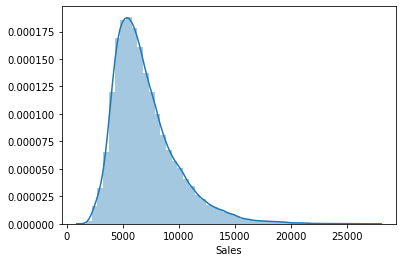

In [22]:
sns.distplot(ytrain)

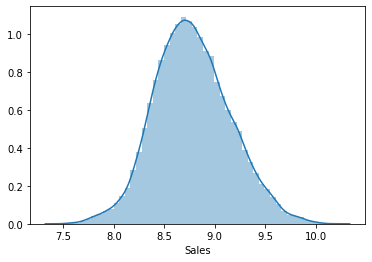

In [23]:
sns.distplot(ytrainlog)

## 2. Fit and validate your model
- **Use Gradient Boosting** or any type of regression model.
- **Beat the baseline:** The estimated baseline Root Mean Squared Logarithmic Error is 0.90, if we guessed the mean sales for every prediction. Remember that RMSE with the log-transformed target is equivalent to RMSLE with the original target. Try to get your error below 0.20.
- **To validate your model, choose any one of these options:**
  - Split the train dataframe into train and validation sets. Put all dates for a given store into the same set. Use xgboost `early_stopping_rounds` with the validation set. 
  - Or, use scikit-learn `cross_val_score`. Put all dates for a given store into the same fold.
  - Or, use scikit-learn `RandomizedSearchCV` for hyperparameter optimization. Put all dates for a given store into the same fold.
- **Get the Validation Error** (multiple times if you try multiple iterations) **and Test Error** (one time, at the end).
  
#### Stretch goal
- Optimize 3+ hyperparameters by searching 10+ "candidates" (possible combinations of hyperparameters). 

In [44]:
# Split into train & validation sets
# All rows for a given date should go in either train or validation
trainval_dates = trainval['Date'].unique()

train_dates, val_dates = train_test_split(
    trainval_dates, random_state=42)

train = trainval[trainval['Date'].isin(train_dates)]
val = trainval[trainval['Date'].isin(val_dates)]


In [45]:
# Now let's Arrange x matrix and y vector
target = 'Sales'

xtrain = train.drop(columns=target)
xval = val.drop(columns=target)
xtest = test.drop(columns=target)

ytrain = train[target]
yval = val[target]
ytest = test[target]

ytrainlog = np.log1p(ytrain)
yvallog = np.log1p(yval)
ytestlog = np.log1p(ytest)

In [35]:
import category_encoders as ce
from xgboost import XGBRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

encoder = ce.OrdinalEncoder()

xtrain_encoded = encoder.fit_transform(xtrain)
xval_encoded = encoder.transform(xval)

eval_set = [(xtrain_encoded, ytrainlog), 
            (xval_encoded, yvallog)]

model = XGBRegressor(n_estimators=2000, verbosity=0, n_jobs=-1)
model.fit(xtrain_encoded, ytrainlog, 
          eval_set=eval_set, eval_metric='rmse', early_stopping_rounds=50)

[0]	validation_0-rmse:7.46384	validation_1-rmse:7.44682
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:6.71803	validation_1-rmse:6.70215
[2]	validation_0-rmse:6.04683	validation_1-rmse:6.03175
[3]	validation_0-rmse:5.44277	validation_1-rmse:5.42843
[4]	validation_0-rmse:4.89916	validation_1-rmse:4.88564
[5]	validation_0-rmse:4.40995	validation_1-rmse:4.3971
[6]	validation_0-rmse:3.96969	validation_1-rmse:3.95736
[7]	validation_0-rmse:3.5735	validation_1-rmse:3.56169
[8]	validation_0-rmse:3.21699	validation_1-rmse:3.20567
[9]	validation_0-rmse:2.89616	validation_1-rmse:2.88526
[10]	validation_0-rmse:2.60749	validation_1-rmse:2.59696
[11]	validation_0-rmse:2.34776	validation_1-rmse:2.33754
[12]	validation_0-rmse:2.11406	validation_1-rmse:2.10415
[13]	validation_0-rmse:1.9038	validation_1-rmse:1.89418
[14]	validation_0-rmse:1.71468	validation_1-rmse:1.70532

[137]	validation_0-rmse:0.078101	validation_1-rmse:0.096628
[138]	validation_0-rmse:0.077839	validation_1-rmse:0.096425
[139]	validation_0-rmse:0.077534	validation_1-rmse:0.096129
[140]	validation_0-rmse:0.077465	validation_1-rmse:0.096656
[141]	validation_0-rmse:0.077349	validation_1-rmse:0.096601
[142]	validation_0-rmse:0.077206	validation_1-rmse:0.096619
[143]	validation_0-rmse:0.076977	validation_1-rmse:0.096394
[144]	validation_0-rmse:0.076728	validation_1-rmse:0.096146
[145]	validation_0-rmse:0.076643	validation_1-rmse:0.096088
[146]	validation_0-rmse:0.076512	validation_1-rmse:0.09641
[147]	validation_0-rmse:0.076308	validation_1-rmse:0.096237
[148]	validation_0-rmse:0.076116	validation_1-rmse:0.096048
[149]	validation_0-rmse:0.075908	validation_1-rmse:0.095829
[150]	validation_0-rmse:0.075838	validation_1-rmse:0.095775
[151]	validation_0-rmse:0.07555	validation_1-rmse:0.095548
[152]	validation_0-rmse:0.07545	validation_1-rmse:0.095469
[153]	validation_0-rmse:0.075319	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)

In [36]:
model.evals_result().keys()

dict_keys(['validation_0', 'validation_1'])

In [48]:
xtest_encoded = encoder.transform(xtest)

eval_set = [(xtrain_encoded, ytrainlog), 
            (xtest_encoded, ytestlog)]

model = XGBRegressor(n_estimators=2000, verbosity=0, n_jobs=-1)
model.fit(xtrain_encoded, ytrainlog, 
          eval_set=eval_set, eval_metric='rmse', early_stopping_rounds=50)



[0]	validation_0-rmse:7.46384	validation_1-rmse:7.49449
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:6.71803	validation_1-rmse:6.74792
[2]	validation_0-rmse:6.04683	validation_1-rmse:6.07608
[3]	validation_0-rmse:5.44277	validation_1-rmse:5.47138
[4]	validation_0-rmse:4.89916	validation_1-rmse:4.92717
[5]	validation_0-rmse:4.40995	validation_1-rmse:4.43744
[6]	validation_0-rmse:3.96969	validation_1-rmse:3.99628
[7]	validation_0-rmse:3.5735	validation_1-rmse:3.59866
[8]	validation_0-rmse:3.21699	validation_1-rmse:3.24176
[9]	validation_0-rmse:2.89616	validation_1-rmse:2.91999
[10]	validation_0-rmse:2.60749	validation_1-rmse:2.63097
[11]	validation_0-rmse:2.34776	validation_1-rmse:2.37046
[12]	validation_0-rmse:2.11406	validation_1-rmse:2.13672
[13]	validation_0-rmse:1.9038	validation_1-rmse:1.92641
[14]	validation_0-rmse:1.71468	validation_1-rmse:1.7373

[137]	validation_0-rmse:0.078101	validation_1-rmse:0.140798
Stopping. Best iteration:
[87]	validation_0-rmse:0.090427	validation_1-rmse:0.139108



In [49]:
valerror = np.expm1(0.094524)
testerror = np.expm1(0.139108)
print('Validation Error:', valerror)
print('Test Error:', testerror)

Validation Error: 0.09913554206945124
Test Error: 0.1492482121083385


## 3. Plot model interpretation visualizations
- Choose any one of these options:
  - Permutation Importances plot
  - Partial Dependency Plot, 1 feature isolation
  - Partial Dependency Plot, 2 feature interaction
  
#### Stretch goals
- Plot 2+ visualizations.
- Use permutation importances for feature selection. 

In [50]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(model, 
                                 scoring='neg_mean_squared_error', 
                                 cv='prefit', 
                                 n_iter=5, 
                                 random_state=42)

permuter.fit(xval_encoded, yvallog)
feature_names = xval_encoded.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.2187 ± 0.0034,Customers
0.0085 ± 0.0002,Promo
0.0068 ± 0.0002,CompetitionDistance
0.0051 ± 0.0001,Store
0.0037 ± 0.0001,CompetitionMonths
0.0033 ± 0.0001,StoreType
0.0030 ± 0.0001,Promo2Weeks
0.0008 ± 0.0001,DayOfWeek
0.0006 ± 0.0001,Assortment
0.0005 ± 0.0000,PromoInterval
